<a href="https://colab.research.google.com/github/MJMortensonWarwick/AAMA2425/blob/main/10_1_genetic_algorithms_with_pygad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genetic Algorithms with PyGAD
This tutorial, heavily inspired by the GARI repository, will use Genetic Algorithms (GA) to recreate a picture of our friend and hero Dr Vinh Doan.

To begin we will install the library:

In [ ]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.2 MB/s eta 0:00:00


Next, we will upload the image we want to recreate. The image ("vinh.jpg") is available on the [my.wbs](https://my.wbs.ac.uk/-/academic/318326/resources/in/1649576,1649572/item/1681937/#/) page for the module. Download the file to your machine and then click "Choose Files" to upload:

In [ ]:
from google.colab import files
upload = files.upload()

Saving vinh.jpg to vinh.jpg


Next we will upload the file to our instance, and convert it to a numerical array:

In [ ]:
import imageio
import numpy as np

image_im = imageio.imread('vinh.jpg')

# because images are a collection of pixels that have a value between
# 0 (for white) and 255 (black), we divided by 255 to return as
# a decimal value (e.g. 0 is white and 1 is full colour)
target_im = np.asarray(image_im/255, dtype=np.float32)

<ipython-input-3-141f8dd6df2d>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_im = imageio.imread('vinh.jpg')


Ignore the "DepreciationWarning". Let's print to screen to see what our target is:

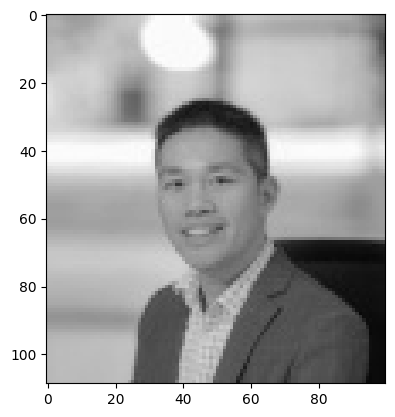

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image_im, cmap='gray', vmin=0, vmax=255)

Now we will specify a couple of functions to convert the image to a vector (i.e. from a 3d image to a 1d array of numbers) and back again. Do not worry about the code here, its quite domain specific and not super-transferable to other analytics workloads.

In [ ]:
import functools
import operator

def img2chromosome(img_arr):
    """
    Represents the image as a 1D vector.

    img_arr: The image to be converted into a vector.

    Returns the vector.
    """

    return np.reshape(a=img_arr, newshape=(functools.reduce(operator.mul, img_arr.shape)))

def chromosome2img(vector, shape):
    """
    Converts a 1D vector into an array.

    vector: The vector to be converted into an array.
    shape: The shape of the target array.

    Returns the array.
    """

    # Check if the vector can be reshaped according to the specified shape.
    if len(vector) != functools.reduce(operator.mul, shape):
        raise ValueError(f"A vector of length {len(vector)} into an array of shape {shape}.")

    return np.reshape(a=vector, newshape=shape)

Next we need to specify our _fitness\_function_ for our GA model - i.e. the measure of success for our algorithm as we evaluate our progress:

In [ ]:
import cupy as cp  # Import CuPy for GPU

# convert the image of Vinh to a vector using the above function
target_chromosome = img2chromosome(target_im)

# the fitness function
# take an proposed solution (model output) and the actual solution
# take the absolute value from subtracting one from the other
def fitness_fun(ga_instance, solution, solution_idx):
    # Convert arrays to CuPy arrays
    target_chromosome_gpu = cp.asarray(target_chromosome)
    solution_gpu = cp.asarray(solution)

    # Perform calculations on GPU. cp.abs gets the absolute value
    fitness = cp.sum(cp.abs(target_chromosome_gpu - solution_gpu))
    fitness = cp.sum(target_chromosome_gpu) - fitness # change to maximisation

    # Return fitness as a regular NumPy scalar
    return fitness.get()

Next we need to specify our GA and its hyperparameters:

In [ ]:
import pygad

# hyperparameters
init_range_low = 0 # minimum value of a pixel is 0
init_range_high = 255 # max value is 255
mutation_by_replacement = True # replace values rather than add to them
random_mutation_min_val= 0 # values should still be 0-255 after mutation
random_mutation_max_val= 255

# specify the GA approach.
ga_instance = pygad.GA(fitness_func=fitness_fun, # specified above
                      num_generations=25000, # total number of runs
                      sol_per_pop=100, #  chromosones each generation
                      num_parents_mating=20, # top 20 parents mate
                      num_genes=target_im.size, # size of each guess/chromosone to match orginal image
                      init_range_low=init_range_low, # specified above
                      init_range_high=init_range_high, # needs to be specified
                      mutation_percent_genes=0.05, # 5% chance of genes mutatation
                      mutation_by_replacement=mutation_by_replacement, # specified above
                      random_mutation_min_val=random_mutation_min_val, # specified above
                      random_mutation_max_val=random_mutation_max_val) # specified above

Now we can run the algorithm - may take a long time!

In [ ]:
ga_instance.run()

Now our model has converged - let's display the results:

In [ ]:
ga_instance.plot_fitness()

We can see fitness progress. _N.B. we could/should have gone further but time is limited in a Lecture-Workshop_

Now let's look at some further results and our final generated image:

In [ ]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Fitness value of the best solution = {solution_fitness}")
print(f"Index of the best solution : {solution_idx}")

# print the generation that produced the best solution
if ga_instance.best_solution_generation != -1:
    print(f"Best fitness value reached after {ga_instance.best_solution_generation} generations.")

# scale solution to int
solution = np.array(solution, dtype=int)

# convert solution to an image using the earlier function
result = chromosome2img(solution, target_im.shape)

# plot the solution photo to screen
plt.imshow(result, cmap='gray', vmin=0, vmax=255)
plt.title("A Lovely Photo of Vinh")
plt.show()

Getting there - but not quite yet. If you want to try some more generations in your own time then you may get something even better! 😺